# Import Libraries, data download

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, log_loss
import operator
import json
from IPython import display
import os
import warnings

np.random.seed(0)
warnings.filterwarnings("ignore")
THRESHOLD = 4

Task: To predict whether the user likes the mobile phone or not. <br>
Assumption: If the average rating of mobile >= threshold, then the user likes it, otherwise not.

<b>Missing values:</b><br>
'Also Known As'(459),'Applications'(421),'Audio Features'(437),'Bezel-less display'(266),'Browser'(449),'Build Material'(338),'Co-Processor'(451),'Display Colour'(457),'Mobile High-Definition Link(MHL)'(472),'Music'(447)
'Email','Fingerprint Sensor Position'(174),'Games'(446),'HDMI'(454),'Heart Rate Monitor'(467),'IRIS Scanner'(467),
'Optical Image Stabilisation'(219),'Other Facilities'(444),'Phone Book'(444),'Physical Aperture'(87),'Quick Charging'(122),'Ring Tone'(444),'Ruggedness'(430),SAR Value(315),'SIM 3'(472),'SMS'(470)', 'Screen Protection'(229),'Screen to Body Ratio (claimed by the brand)'(428),'Sensor'(242),'Software Based Aperture'(473),
'Special Features'(459),'Standby time'(334),'Stylus'(473),'TalkTime'(259), 'USB Type-C'(374),'Video Player'(456),
'Video Recording Features'(458),'Waterproof'(398),'Wireless Charging','USB OTG Support'(159), 'Video ,'Recording'(113),'Java'(471),'Browser'(448)

<b>Very low variance:</b><br>
'Architecture'(most entries are 64-bit),'Audio Jack','GPS','Loudspeaker','Network','Network Support','Other Sensors'(28),'SIM Size', 'VoLTE'


<b>Multivalued:</b><br>
'Colours','Custom UI','Model'(1),'Other Sensors','Launch Date'

<b>Not important:</b><br>
'Bluetooth', 'Settings'(75),'Wi-Fi','Wi-Fi Features'

<b>Doubtful:</b><br>
'Aspect Ratio','Autofocus','Brand','Camera Features','Fingerprint Sensor'(very few entries are missing),
'Fingerprint Sensor Position', 'Graphics'(multivalued),'Image resolution'(multivalued),'SIM Size','Sim Slot(s)', 'User Available Storage', 'SIM 1', 'SIM 2','Shooting Modes', 'Touch Screen'(24), 'USB Connectivity'
    
<b>To check:</b><br>
'Display Type','Expandable Memory','FM Radio'

<b>High Correlation with other features</b><br>
'SIM Slot(s)' high correlation with SIM1
'Weight' has high high correlation with capacity , screen-to-body ratio
'Height' - screen size is also there
    
<b>Given a mobile, we can't directly get these features</b><br>
'Rating Count', 'Review Count'

<b>Keeping:</b><br>
'Capacity','Flash'(17),'Height'(22),'Internal Memory'(20, require cleaning),'Operating System'(25, require cleaning), 'Pixel Density'(1, clean it),'Processor'(22, clean it), 'RAM'(17, clean), 'Rating','Resolution'(cleaning), 'Screen Resolution','Screen Size', 'Thickness'(22), 'Type','User Replaceable','Weight'(cleaning),'Sim Size'(), 'Other Sensors'(28), 'Screen to Body Ratio (calculated)','Width',


In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


    100% |████████████████████████████████| 993kB 15.4MB/s 


In [0]:

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1dzVSrZh-wLA1-k8k7f54_6rr9oZuThOG'
downloaded = drive.CreateFile({'id': file_id})    #https://drive.google.com/open?id=1dzVSrZh-wLA1-k8k7f54_6rr9oZuThOG
print('Downloaded content "{}"'.format(downloaded.GetContentString()))

In [0]:
downloaded.GetContentFile('train_local.csv')

In [0]:

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1AojWxQ85ZgMGBC4JdSO5gTjiQT6uVqYg'   #https://drive.google.com/open?id=1AojWxQ85ZgMGBC4JdSO5gTjiQT6uVqYg
downloaded = drive.CreateFile({'id': file_id})    #https://drive.google.com/open?id=1dzVSrZh-wLA1-k8k7f54_6rr9oZuThOG
print('Downloaded content "{}"'.format(downloaded.GetContentString()))

In [0]:
downloaded.GetContentFile('test_local.csv')

In [0]:
# read data from file
#train = pd.read_csv("../input/train.csv") 
#test = pd.read_csv("../input/test.csv")

train = pd.read_csv("train_local.csv")
test = pd.read_csv("test_local.csv")

# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 355
Number of features in train: 99
Number of data points in test: 119
Number of features in test: 98


In [0]:
def data_clean(data):
    
    # Let's first remove all missing value features
    columns_to_remove = ['Also Known As','Applications','Audio Features','Bezel-less display'
                         'Browser','Build Material','Co-Processor','Browser'
                         'Display Colour','Mobile High-Definition Link(MHL)',
                         'Music', 'Email','Fingerprint Sensor Position',
                         'Games','HDMI','Heart Rate Monitor','IRIS Scanner', 
                         'Optical Image Stabilisation','Other Facilities',
                         'Phone Book','Physical Aperture','Quick Charging',
                         'Ring Tone','Ruggedness','SAR Value','SIM 3','SMS',
                         'Screen Protection','Screen to Body Ratio (claimed by the brand)',
                         'Sensor','Software Based Aperture', 'Special Features',
                         'Standby time','Stylus','TalkTime', 'USB Type-C',
                         'Video Player', 'Video Recording Features','Waterproof',
                         'Wireless Charging','USB OTG Support', 'Video Recording','Java']

    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    #Features having very low variance 
    columns_to_remove = ['Architecture','Audio Jack','GPS','Loudspeaker','Network','Network Support','VoLTE']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    # Multivalued:
    columns_to_remove = ['Architecture','Launch Date','Audio Jack','GPS','Loudspeaker','Network','Network Support','VoLTE', 'Custom UI']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    # Not much important
    columns_to_remove = ['Bluetooth', 'Settings','Wi-Fi','Wi-Fi Features']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]
    
    return data

# Removing features

In [0]:
train = data_clean(train)
test = data_clean(test)

removing all those data points in which more than 15 features are missing 

In [0]:
train = train[(train.isnull().sum(axis=1) <= 15)]
# You shouldn't remove data points from test set
#test = test[(test.isnull().sum(axis=1) <= 15)]

In [0]:
# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 341
Number of features in train: 47
Number of data points in test: 119
Number of features in test: 46


In [0]:
print(train.shape)
print(list(train.columns.values))
#['Display Type', 'RAM', 'Screen Size', 'Weight', 'SIM Size', 'NFC', 'Model', 'PhoneId', 'SIM 1', 'Touch Screen', 'Fingerprint Sensor', 'Display Colour', 'Browser', 'SIM 2', 'USB Connectivity', 'Capacity', 'Brand', 'Expandable Memory', 'Other Sensors', 'Rating Count', 'Internal Memory', 'Shooting Modes', 'Height', 'Screen to Body Ratio (calculated)', 'Image Resolution', 'Type', 'Bezel-less display', 'Camera Features', 'Pixel Density', 'Resolution', 'Colours', 'Flash', 'User Replaceable', 'Operating System', 'Autofocus', 'Aspect Ratio', 'Screen Resolution', 'Thickness', 'FM Radio', 'Processor', 'SIM Slot(s)', 'Chipset', 'Review Count', 'Width', 'Graphics', 'User Available Storage']

(355, 47)
['SIM 2', 'Touch Screen', 'Capacity', 'NFC', 'Fingerprint Sensor', 'SIM Size', 'Other Sensors', 'Screen Resolution', 'Model', 'Camera Features', 'Internal Memory', 'User Available Storage', 'Bezel-less display', 'Thickness', 'Height', 'Colours', 'Browser', 'Screen to Body Ratio (calculated)', 'SIM Slot(s)', 'FM Radio', 'Expandable Memory', 'RAM', 'Shooting Modes', 'Weight', 'Operating System', 'Image Resolution', 'Type', 'Autofocus', 'User Replaceable', 'Pixel Density', 'Rating Count', 'Display Type', 'Flash', 'Width', 'SIM 1', 'Aspect Ratio', 'Processor', 'Brand', 'Resolution', 'Rating', 'Review Count', 'Chipset', 'USB Connectivity', 'Display Colour', 'PhoneId', 'Graphics', 'Screen Size']


# Filling Missing values  (data preprocessing)


In [0]:
def for_integer(test):
    try:
        test = test.strip()       #removes leading and trailing whitespaces
        return int(test.split(' ')[0])
    except IOError:
           pass
    except ValueError:
        pass
    except:
        pass

def for_string(test):
    try:
        test = test.strip()
        return (test.split(' ')[0])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass

def for_float(test):
    try:
        test = test.strip()
        return float(test.split(' ')[0])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass
def find_freq(test):
    try:
        test = test.strip()
        test = test.split(' ')
        if test[2][0] == '(':
            return float(test[2][1:])
        return float(test[2])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass

    
def for_Internal_Memory(test):
    try:
        test = test.strip()
        test = test.split(' ')
        if test[1] == 'GB':
            return int(test[0])
        if test[1] == 'MB':
#             print("here")
            return (int(test[0]) * 0.001)
    except IOError:
           pass
    except ValueError:
        pass
    except:
        pass
    
def find_freq(test):
    try:
        test = test.strip()
        test = test.split(' ')
        if test[2][0] == '(':
            return float(test[2][1:])   #   Octa core, 1.8 GHz, Cortex A53 Average ▾Proces...
        return float(test[2])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass


In [0]:
def data_clean_2(x):
    data = x.copy()
    
    data['Capacity'] = data['Capacity'].apply(for_integer)    #Pandas.apply allow the users to pass a function and apply it on every single value of the Pandas series. It comes as a huge improvement for the pandas library as this function helps to segregate data according to the conditions required due to which it is efficiently used in data science and machine learning.

    data['Height'] = data['Height'].apply(for_float)
    data['Height'] = data['Height'].fillna(data['Height'].mean())

    data['Internal Memory'] = data['Internal Memory'].apply(for_Internal_Memory)

    data['Pixel Density'] = data['Pixel Density'].apply(for_integer)

    data['Internal Memory'] = data['Internal Memory'].fillna(data['Internal Memory'].median())
    data['Internal Memory'] = data['Internal Memory'].astype(int)

    data['RAM'] = data['RAM'].apply(for_integer)
    data['RAM'] = data['RAM'].fillna(data['RAM'].median())
    data['RAM'] = data['RAM'].astype(int)

    data['Resolution'] = data['Resolution'].apply(for_integer)
    data['Resolution'] = data['Resolution'].fillna(data['Resolution'].median())
    data['Resolution'] = data['Resolution'].astype(int)

    data['Screen Size'] = data['Screen Size'].apply(for_float)

    data['Thickness'] = data['Thickness'].apply(for_float)
    data['Thickness'] = data['Thickness'].fillna(data['Thickness'].mean())
    data['Thickness'] = data['Thickness'].round(2)

    data['Type'] = data['Type'].fillna('Li-Polymer')

    data['Screen to Body Ratio (calculated)'] = data['Screen to Body Ratio (calculated)'].apply(for_float)
    data['Screen to Body Ratio (calculated)'] = data['Screen to Body Ratio (calculated)'].fillna(data['Screen to Body Ratio (calculated)'].mean())
    data['Screen to Body Ratio (calculated)'] = data['Screen to Body Ratio (calculated)'].round(2)

    data['Width'] = data['Width'].apply(for_float)
    data['Width'] = data['Width'].fillna(data['Width'].mean())
    data['Width'] = data['Width'].round(2)

    data['Flash'][data['Flash'].isna() == True] = "Other"

    data['User Replaceable'][data['User Replaceable'].isna() == True] = "Other"

    data['Num_cores'] = data['Processor'].apply(for_string)
    data['Num_cores'][data['Num_cores'].isna() == True] = "Other"


    data['Processor_frequency'] = data['Processor'].apply(find_freq)
    #because there is one entry with 208MHz values, to convert it to GHz
    data['Processor_frequency'][data['Processor_frequency'] > 200] = 0.208
    data['Processor_frequency'] = data['Processor_frequency'].fillna(data['Processor_frequency'].mean())
    data['Processor_frequency'] = data['Processor_frequency'].round(2)

    data['Camera Features'][data['Camera Features'].isna() == True] = "Other"

    #simplifyig Operating System to os_name for simplicity
    data['os_name'] = data['Operating System'].apply(for_string)
    data['os_name'][data['os_name'].isna() == True] = "Other"

    data['Sim1'] = data['SIM 1'].apply(for_string)

    data['SIM Size'][data['SIM Size'].isna() == True] = "Other"

    data['Image Resolution'][data['Image Resolution'].isna() == True] = "Other"

    data['Fingerprint Sensor'][data['Fingerprint Sensor'].isna() == True] = "Other"

    data['Expandable Memory'][data['Expandable Memory'].isna() == True] = "No"

    data['Weight'] = data['Weight'].apply(for_integer)
    data['Weight'] = data['Weight'].fillna(data['Weight'].mean())
    data['Weight'] = data['Weight'].astype(int)

    data['SIM 2'] = data['SIM 2'].apply(for_string)
    data['SIM 2'][data['SIM 2'].isna() == True] = "Other"
    
    return data

In [0]:
#print(train['Capacity'])      0      4000 mAh
train = data_clean_2(train)
#print(train['Capacity'])     0      4000
test = data_clean_2(test)

# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 341
Number of features in train: 51
Number of data points in test: 119
Number of features in test: 50


In [0]:
print(list(train.columns.values))
#['Display Type', 'RAM', 'Screen Size', 'Weight', 'SIM Size', 'NFC', 'Model', 'PhoneId', 'SIM 1', 'Touch Screen', 'Fingerprint Sensor', 'Display Colour', 'Browser', 'SIM 2', 'USB Connectivity', 'Capacity', 'Brand', 'Expandable Memory', 'Other Sensors', 'Rating Count', 'Internal Memory', 'Shooting Modes', 'Height', 'Screen to Body Ratio (calculated)', 'Image Resolution', 'Type', 'Bezel-less display', 'Camera Features', 'Pixel Density', 'Resolution', 'Colours', 'Flash', 'User Replaceable', 'Operating System', 'Autofocus', 'Aspect Ratio', 'Screen Resolution', 'Thickness', 'FM Radio', 'Processor', 'SIM Slot(s)', 'Chipset', 'Review Count', 'Width', 'Graphics', 'User Available Storage', 'Num_cores', 'Processor_frequency', 'os_name', 'Sim1']


['SIM 2', 'Touch Screen', 'Capacity', 'NFC', 'Fingerprint Sensor', 'SIM Size', 'Other Sensors', 'Screen Resolution', 'Model', 'Camera Features', 'Internal Memory', 'User Available Storage', 'Bezel-less display', 'Thickness', 'Height', 'Colours', 'Browser', 'Screen to Body Ratio (calculated)', 'SIM Slot(s)', 'FM Radio', 'Expandable Memory', 'RAM', 'Shooting Modes', 'Weight', 'Operating System', 'Image Resolution', 'Type', 'Autofocus', 'User Replaceable', 'Pixel Density', 'Rating Count', 'Display Type', 'Flash', 'Width', 'SIM 1', 'Aspect Ratio', 'Processor', 'Brand', 'Resolution', 'Rating', 'Review Count', 'Chipset', 'USB Connectivity', 'Display Colour', 'PhoneId', 'Graphics', 'Screen Size', 'Num_cores', 'Processor_frequency', 'os_name', 'Sim1']


In [0]:
print(train['Processor'])
#0      Octa core, 1.8 GHz, Cortex A53 Average ▾Proces...

Not very important feature

In [0]:
def data_clean_3(x):
    
    data = x.copy()

    columns_to_remove = ['User Available Storage','SIM Size','Chipset','Processor','Autofocus','Aspect Ratio','Touch Screen',
                        'Bezel-less display','Operating System','SIM 1','USB Connectivity','Other Sensors','Graphics','FM Radio',
                        'NFC','Shooting Modes','Browser','Display Colour' ]

    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]


    columns_to_remove = [ 'Screen Resolution','User Replaceable','Camera Features',
                        'Thickness', 'Display Type']

    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]


    columns_to_remove = ['Fingerprint Sensor', 'Flash', 'Rating Count', 'Review Count','Image Resolution','Type','Expandable Memory',\
                        'Colours','Width','Model']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    return data

In [0]:
train = data_clean_3(train)
test = data_clean_3(test)

# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 341
Number of features in train: 18
Number of data points in test: 119
Number of features in test: 17


In [0]:
# one hot encoding            for categorical feature with more then two catgories,one hot is used for example we have colour as [red, yellow, green, purple] then we can make an array[0 0 0 0]  and for every row, which ever colour is true, change the corresponding index representing that colour to 1]


#steps
#1 combine test train, drop rating from train
#2 do one hot encoding
#separate test and train again according to their IDs as stored before in variables train_ids, test_ids


train_ids = train['PhoneId']
test_ids = test['PhoneId']

cols = list(test.columns)
cols.remove('PhoneId')
cols.insert(0, 'PhoneId')

combined = pd.concat([train.drop('Rating', axis=1)[cols], test[cols]])

print(combined.shape)
print(combined.columns)

combined = pd.get_dummies(combined)
print(combined.shape)
print(combined.columns)

train_new = combined[combined['PhoneId'].isin(train_ids)]
test_new = combined[combined['PhoneId'].isin(test_ids)]

(460, 17)
Index(['PhoneId', 'SIM 2', 'Capacity', 'Internal Memory', 'Weight', 'Sim1',
       'Brand', 'Resolution', 'Processor_frequency', 'Height', 'os_name',
       'Num_cores', 'Pixel Density', 'Screen to Body Ratio (calculated)',
       'Screen Size', 'SIM Slot(s)', 'RAM'],
      dtype='object')
(460, 87)
Index(['PhoneId', 'Capacity', 'Internal Memory', 'Weight', 'Resolution',
       'Processor_frequency', 'Height', 'Pixel Density',
       'Screen to Body Ratio (calculated)', 'Screen Size', 'RAM', 'SIM 2_2G',
       'SIM 2_3G', 'SIM 2_4G', 'SIM 2_Other', 'Sim1_2G', 'Sim1_3G', 'Sim1_4G',
       'Brand_10.or', 'Brand_Apple', 'Brand_Asus', 'Brand_Billion',
       'Brand_Blackberry', 'Brand_Comio', 'Brand_Coolpad', 'Brand_Do',
       'Brand_Gionee', 'Brand_Google', 'Brand_HTC', 'Brand_Honor',
       'Brand_Huawei', 'Brand_InFocus', 'Brand_Infinix', 'Brand_Intex',
       'Brand_Itel', 'Brand_Jivi', 'Brand_Karbonn', 'Brand_LG', 'Brand_Lava',
       'Brand_LeEco', 'Brand_Lenovo', 'Brand_L

In [0]:
print(list(train_new.columns.values))
print(list(test_new.columns.values))

['PhoneId', 'Capacity', 'Internal Memory', 'Weight', 'Resolution', 'Processor_frequency', 'Height', 'Pixel Density', 'Screen to Body Ratio (calculated)', 'Screen Size', 'RAM', 'SIM 2_2G', 'SIM 2_3G', 'SIM 2_4G', 'SIM 2_Other', 'Sim1_2G', 'Sim1_3G', 'Sim1_4G', 'Brand_10.or', 'Brand_Apple', 'Brand_Asus', 'Brand_Billion', 'Brand_Blackberry', 'Brand_Comio', 'Brand_Coolpad', 'Brand_Do', 'Brand_Gionee', 'Brand_Google', 'Brand_HTC', 'Brand_Honor', 'Brand_Huawei', 'Brand_InFocus', 'Brand_Infinix', 'Brand_Intex', 'Brand_Itel', 'Brand_Jivi', 'Brand_Karbonn', 'Brand_LG', 'Brand_Lava', 'Brand_LeEco', 'Brand_Lenovo', 'Brand_Lephone', 'Brand_Lyf', 'Brand_Meizu', 'Brand_Micromax', 'Brand_Mobiistar', 'Brand_Moto', 'Brand_Motorola', 'Brand_Nokia', 'Brand_Nubia', 'Brand_OPPO', 'Brand_OnePlus', 'Brand_Oppo', 'Brand_Panasonic', 'Brand_Razer', 'Brand_Realme', 'Brand_Reliance', 'Brand_Samsung', 'Brand_Sony', 'Brand_Spice', 'Brand_Tecno', 'Brand_Ulefone', 'Brand_VOTO', 'Brand_Vivo', 'Brand_Xiaomi', 'Brand_Xi

In [0]:
#train_dummy=train_new
train_new = train_new.merge(train[['PhoneId', 'Rating']], on='PhoneId')


In [0]:
print(train_new[['PhoneId','Rating']])

In [0]:
# check the number of features and data points in train
print("Number of data points in train: %d" % train_new.shape[0])
print("Number of features in train: %d" % train_new.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test_new.shape[0])
print("Number of features in test: %d" % test_new.shape[1])

Number of data points in train: 341
Number of features in train: 88
Number of data points in test: 119
Number of features in test: 87


In [0]:
train_new.head()

,PhoneId,Capacity,Internal Memory,Weight,Resolution,Processor_frequency,Height,Pixel Density,Screen to Body Ratio (calculated),Screen Size,...,Num_cores_Hexa,Num_cores_Octa,Num_cores_Other,Num_cores_Quad,Num_cores_Tru-Octa,"SIM Slot(s)_Dual SIM, GSM+CDMA","SIM Slot(s)_Dual SIM, GSM+GSM","SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE","SIM Slot(s)_Single SIM, GSM",Rating
0,0,4000,64,182,20,1.8,157.9,403,80.68,6.26,...,0,1,0,0,0,0,0,1,0,4.5
1,1,4230,32,168,8,1.8,156.2,271,80.85,6.20,...,0,1,0,0,0,0,0,1,0,4.5
2,2,3500,32,168,25,2.1,157.0,409,83.68,6.30,...,0,1,0,0,0,0,0,1,0,4.4
3,4,3300,64,169,24,2.2,159.8,411,74.78,6.00,...,0,1,0,0,0,0,1,0,0,4.3
4,5,3750,64,175,16,2.2,160.4,396,84.23,6.50,...,0,1,0,0,0,0,0,1,0,4.4


In [0]:
train_new.shape

(355, 91)

In [0]:
test_new.head()

,PhoneId,Capacity,Internal Memory,Weight,Resolution,Processor_frequency,Height,Pixel Density,Screen to Body Ratio (calculated),Screen Size,...,Num_cores_Dual,Num_cores_Hexa,Num_cores_Octa,Num_cores_Other,Num_cores_Quad,Num_cores_Tru-Octa,"SIM Slot(s)_Dual SIM, GSM+CDMA","SIM Slot(s)_Dual SIM, GSM+GSM","SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE","SIM Slot(s)_Single SIM, GSM"
0,3,4230,16,168,5,1.8,156.2,271,80.85,6.20,...,0,0,1,0,0,0,0,0,1,0
1,11,5000,64,205,12,1.8,156.0,402,81.60,6.20,...,0,0,1,0,0,0,0,0,1,0
2,13,3500,64,169,25,2.0,156.7,409,83.84,6.30,...,0,0,1,0,0,0,0,0,1,0
3,16,3500,64,169,16,2.0,156.7,409,83.84,6.30,...,0,0,1,0,0,0,0,0,1,0
4,19,4000,64,181,20,1.8,158.6,403,77.43,5.99,...,0,0,1,0,0,0,0,0,1,0


# X_train, Y_train

In [0]:
Y_train=train_new['Rating']
X_train=train_new.drop('Rating',axis=1)   #drop rating

In [0]:
print(Y_train,X_train['PhoneId'])


In [0]:
print(train_new[['PhoneId','Rating']])

In [0]:
Y_train.shape

X_train.shape 

(341, 87)

In [0]:
#X_train=X_train.drop('PhoneId',axis=1)
print(list(X_train.columns.values))

['PhoneId', 'Capacity', 'Internal Memory', 'Weight', 'Resolution', 'Processor_frequency', 'Height', 'Pixel Density', 'Screen to Body Ratio (calculated)', 'Screen Size', 'RAM', 'SIM 2_2G', 'SIM 2_3G', 'SIM 2_4G', 'SIM 2_Other', 'Sim1_2G', 'Sim1_3G', 'Sim1_4G', 'Brand_10.or', 'Brand_Apple', 'Brand_Asus', 'Brand_Billion', 'Brand_Blackberry', 'Brand_Comio', 'Brand_Coolpad', 'Brand_Do', 'Brand_Gionee', 'Brand_Google', 'Brand_HTC', 'Brand_Honor', 'Brand_Huawei', 'Brand_InFocus', 'Brand_Infinix', 'Brand_Intex', 'Brand_Itel', 'Brand_Jivi', 'Brand_Karbonn', 'Brand_LG', 'Brand_Lava', 'Brand_LeEco', 'Brand_Lenovo', 'Brand_Lephone', 'Brand_Lyf', 'Brand_Meizu', 'Brand_Micromax', 'Brand_Mobiistar', 'Brand_Moto', 'Brand_Motorola', 'Brand_Nokia', 'Brand_Nubia', 'Brand_OPPO', 'Brand_OnePlus', 'Brand_Oppo', 'Brand_Panasonic', 'Brand_Razer', 'Brand_Realme', 'Brand_Reliance', 'Brand_Samsung', 'Brand_Sony', 'Brand_Spice', 'Brand_Tecno', 'Brand_Ulefone', 'Brand_VOTO', 'Brand_Vivo', 'Brand_Xiaomi', 'Brand_Xi

# Binarise

In [0]:
X_train_binarised=X_train.drop('PhoneId',axis=1)
X_train_binarised = X_train_binarised.apply(pd.cut, bins=2, labels=[0,1])
Y_train_binarised=Y_train.map(lambda x : 1 if x>=4 else 0)    #threshold is 4

In [0]:
print(X_train_binarised)
print(Y_train_binarised)

In [0]:
train_new.groupby('Rating').mean()

# convert into np array

In [0]:
Y_train_binarised = Y_train_binarised.values
X_train_binarised = X_train_binarised.values

# MP neuron model


In [0]:
for b in range(X_train_binarised.shape[1]+1):
  accurate_rows=0
  for x,y in zip(X_train_binarised,Y_train_binarised):
    y_pred=(np.sum(x)>=b)
    if y_pred == y:
      accurate_rows+=1
  print(b,accurate_rows/X_train_binarised.shape[0])

In [0]:
b=0
max_accuracy=0
for i in range(X_train_binarised.shape[1]+1):
  accurate_rows=0
  for x,y in zip(X_train_binarised,Y_train_binarised):
    y_pred=(np.sum(x)>=i)
    if y_pred == y:
      accurate_rows+=1
  accuracy=(accurate_rows/X_train_binarised.shape[0])
  #print(accuracy)
  if accuracy>max_accuracy:
    max_accuracy=accuracy
    b=i
    
print(b, max_accuracy)

8 0.7008797653958945


# MP Neuron testing

In [0]:
test_new1=test_new.drop('PhoneId',axis=1)

In [0]:
X_test_binarised = test_new1.apply(pd.cut, bins=2, labels=[0,1])


In [0]:
print(X_test_binarised)

In [0]:
b=8
y_test=[]
for x,id in zip(X_test_binarised,test_ids):
  
  y_pred=int(np.sum(x)>=b)
  print(id,np.sum(x),b, y_pred)
  y_test.append(y_pred)

In [0]:
submission = pd.DataFrame({'PhoneId':test_new['PhoneId'], 'Class':y_test})
submission = submission[['PhoneId', 'Class']]

In [0]:
submission['Class'].value_counts()

1    115
0      4
Name: Class, dtype: int64

In [0]:
print(submission)

In [0]:
submission.to_csv("submission.csv", index=False)

# Preceptron

In [0]:
"""
WiXi>=0 i=0 to n

for x in X_train:
if wixi<0 and y=1
w=w+x 
b=b-1

if wixi>=0 and y==0
w=w-x
b=b+1

learning rate

epoch

input- real

output- binarized
"""

# Input

## train test

In [0]:
X_train_per=X_train.drop('PhoneId',axis=1)
Y_train_per=Y_train.map(lambda x: 1 if x>=4 else 0)

In [0]:
X_train_per=X_train_per.values
Y_train_per=Y_train_per.values

## wt matrix

In [0]:
w=np.ones(X_train_per.shape[1])

# model, algo

In [0]:
b=0
for x,y in zip(X_train_per,Y_train_per):
  
  y_pred=np.dot(x,w)
  
  if y_pred<b and y==1:
    w = w + x 
    b = b - 1
  
  
  elif y_pred>=b and y==0:
    w = w - x
    b = b + 1
    
    
print(b)

y_train_pred=[]


for x,y in zip(X_train_per,Y_train_per):
 
  y_pred=int(np.dot(w,x)>=b)
  
  y_train_pred.append(y_pred)
  
  
    
    
print(accuracy_score(y_train_per,Y_train_per))

1
0.6979472140762464


## with epoch

In [0]:
b=0
w=np.ones(X_train.shape[1])
max_accuaracy=0
for epoch in range(1050):
  for x,y in zip(X_train_per,Y_train_per):

    y_pred=np.dot(x,w)

    if y_pred<b and y==1:
      w = w + x 
      b = b - 1


    elif y_pred>=b and y==0:
      w = w - x
      b = b + 1

      
  y_train_pred=[]


  for x,y in zip(X_train_per,Y_train_per):

    y_pred=int(np.dot(w,x)>=b)

    y_train_pred.append(y_pred)



  accuracy=accuracy_score(y_train_pred,Y_train_per)
  if accuracy>max_accuracy:
    max_accuracy=accuracy
    final_b=b
    
    
print(max_accuracy,b)


"""
150 0.7360703812316716 -69
1000 0.7565982404692082 -713
1050 0.7595307917888563 -1795
1000 0.7595307917888563 -713
1000 0.7565982404692082 -772
"""

0.7595307917888563 -1795


'\n150 0.7360703812316716 -69\n1000 0.7565982404692082 -713\n\n'

## with learning rate

In [0]:
def my_perceptron(X,Y,b=0,lr=1,e=1):
  w=np.ones(X.shape[1])
  max_accuracy=0
  for epoch in range(e):
    for x,y in zip(X,Y):

      y_pred=np.dot(x,w)

      if y_pred<b and y==1:
        w = w + x*lr
        b = b - 1*lr


      elif y_pred>=b and y==0:
        w = w - x*lr
        b = b + 1*lr


    y_train_pred=[]


    for x,y in zip(X,Y):

      y_pred=int(np.dot(w,x)>=b)

      y_train_pred.append(y_pred)



    accuracy=accuracy_score(y_train_pred,Y_train_per)
    if accuracy>max_accuracy:
      max_accuracy=accuracy
      final_b=b


  return max_accuracy,b

In [0]:
accuracy,b = my_perceptron(X_train_per,Y_train_per,0,1,80)
print(accuracy,b)


"""
0,0.2,1000 75.66          epoch=1000,700,600,500,400,300,200,180   l=.2,.9,1
0.7565982404692082 -41    0,1,80

"""

0.7565982404692082 -41


'\n0,0.2,1000 75.66          epoch=1000,700,600,500,400,300,200,180   l=.2,.9,1\n\n'

# Testing

In [0]:
test_per=test_new.drop('PhoneId',axis=1)

In [0]:
test_per=test_per.values

In [0]:
def predict(X,b):
  y_train_pred=[]
  for x in X:

      y_pred=int(np.dot(w,x)>=b)

      y_train_pred.append(y_pred)
      
  return y_train_pred 



In [0]:
y_test=predict(test_per,41)

In [0]:
submission = pd.DataFrame({'PhoneId':test_new['PhoneId'], 'Class':y_test})
submission = submission[['PhoneId', 'Class']]

In [0]:
submission['Class'].value_counts()

1    119
Name: Class, dtype: int64

In [0]:
submission.to_csv("submission-preceptron.csv", index=False)

# Dummy Solution

In [0]:
submission = pd.DataFrame({'PhoneId':test_new['PhoneId'], 'Class':[0]*test_new.shape[0]})
submission = submission[['PhoneId', 'Class']]
submission.head()

,PhoneId,Class
0,3,0
1,11,0
2,13,0
3,16,0
4,19,0


In [0]:
submission.to_csv("submission.csv", index=False)

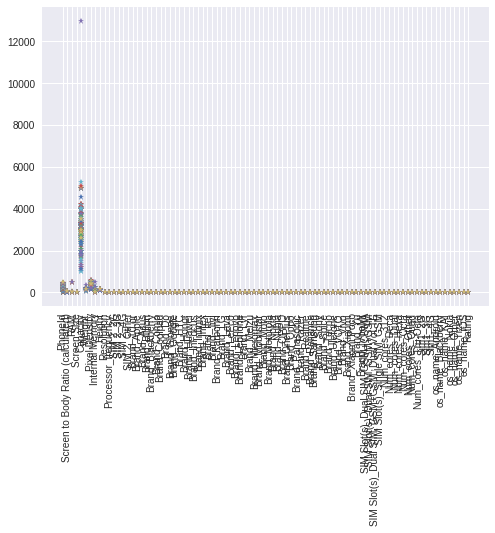

In [0]:
"""
WRITE YOUR MODELLING CODE HERE




what i have

train data stored in train_new    has rating parameter
test data stored in test_new      doesn't have rating parameter

what i have to do
predict whether the phone will be liked   


which parameter decides - rating
if rating is > than a threshold, phone is liked

so, i have to decide that which parameter cause what type of rating


model
mp neuron
input- 0 or 1 format
output- 0 or 1 format

learning
𝑦=1,if ∑𝑖 𝑥𝑖>=𝑏

𝑦=0,otherwise

learn b.
1 0 0 1 0 1      1
1 0 1 0 1 0      0



step one
binarize the inputs

"""

plt.plot(train_new.T,'*')
plt.xticks(rotation='vertical')     #rotates th names on x-axis vertically

plt.show()
#print(train_new)